# Introduction

There are several ways to train cuts. This is using a simulation - drawing from a probability distribution to decide if a "item" should be in or out.

This is based on the paper [_Gradient Estimation Using Stochastic Computation Graphs_](https://arxiv.org/abs/1506.05254).

## The Problem

We'll try to do this with a super simple problem - a 2D distribution that has background and signal, and then train two cuts to try to get the best S/B possible.

In [3]:
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt

_ = plt.ion()

## Data Generation

Two gaussian distributions. Build training data and truth for later training.

In [4]:
# Fixing random state for reproducibility
np.random.seed(19680801)

# Sizes of the samples. Keep same size to help
# training - as reweighing will happen anyway.
N_sig = 10000
N_back = 20000

#
data_2D_sig = np.random.multivariate_normal(
    [1.5, 2.0], [[0.5, 0.2], [0.2, 0.5]], [N_sig]
)
data_2D_back = np.random.multivariate_normal(
    [0.0, 0.0], [[9.0, 0.0], [0.0, 9.0]], [N_back]
)

data = jnp.asarray(np.concatenate([data_2D_sig, data_2D_back]))
data_truth = jnp.asarray(np.concatenate([np.ones(N_sig), np.zeros(N_back)]))

Plot the signal and background on top of each other using a kde density plot (so your eye can figure out what is going on).

<Axes: >

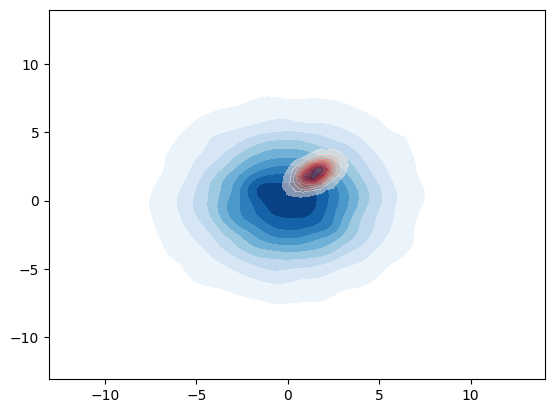

In [5]:
sns.kdeplot(x=data_2D_back[:, 0], y=data_2D_back[:, 1], cmap="Blues", fill=True)
sns.kdeplot(x=data_2D_sig[:, 0], y=data_2D_sig[:, 1], cmap="Reds", fill=True, alpha=0.5)

## $S/B$ and simple straight cuts

We first define the test statistic:

In [6]:
def f(is_sig):
    '''Return the the S/B ratio given a list of 1 or 0 for signal or background'''
    n_sig = jnp.sum(is_sig)
    n_back = len(is_sig) - n_sig
    return n_sig / n_back

And the $S/B$ for the data with no cuts...

In [8]:
print(f(data_truth))

0.5


Next, lets do this for simple straight cuts.

In [9]:
def straight_cuts (data, cuts):
    '''Return an array of 1 or 0 if the data passes the cuts
    for each cut in cuts'''
    return (data[:, 0] > cuts[0]) & (data[:, 1] > cuts[1])

A really simple grid search just to show we know what we are doing here, kind-of.

Note this next cell takes 1 minute 49 seconds on my laptop...

In [10]:
x_y_cuts = np.linspace(-10, 10, 20)
cuts = np.array(np.meshgrid(x_y_cuts, x_y_cuts)).T.reshape(-1, 2)
values = np.array([f(data_truth[straight_cuts(data, cut)]) for cut in cuts])

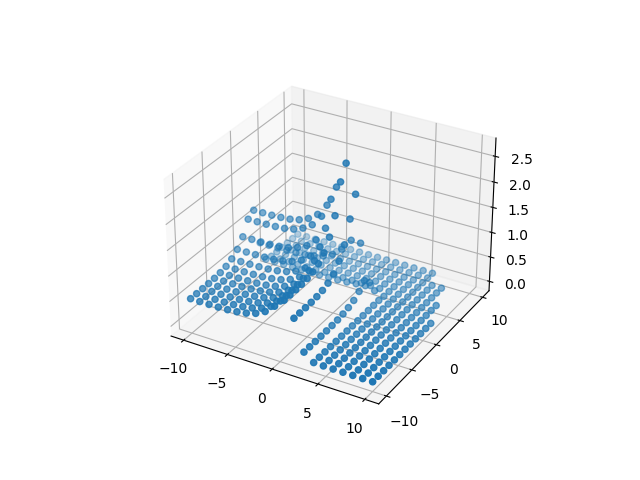

In [12]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cuts[:, 0], cuts[:, 1], values)
plt.show()